In [ ]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import os

In [ ]:
from google.colab import drive
gpath = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ***Loading CT scan NPZs***

In [ ]:
path = '/content/drive/MyDrive/ct scans/'

print(os.listdir(path))

['ct_scan_1.npz', 'ct_scan_2.npz', 'ct_scan_3.npz', 'ct_scan_4.npz', 'ct_scan_5.npz', 'ct_scan_6.npz', 'ct_scan_7.npz', 'ct_scan_8.npz', 'history.csv', 'ct_scan_discriminator.h5', 'ct_scan_generator.h5', 'gt']


In [ ]:
i = 0
for npz_name in os.listdir(path):

  complete_address = os.path.join(path,npz_name)

  file_extension = complete_address.split(".")[-1]


  if file_extension == "npz":

    ct_scans = np.load(complete_address)

    if i == 0:
      complete_array = ct_scans["arr_0"]

      complete_array = np.transpose(complete_array, (1,2,0))
      pass

    if i > 0:

      ct_scan_array = ct_scans["arr_0"]

      if ct_scan_array.shape[0] != 256:

        ct_scan_array = np.transpose(ct_scan_array, (1,2,0))
        pass


      complete_array = np.concatenate((complete_array, ct_scan_array),axis=2)

      print(ct_scan_array.shape)

      pass

    pass


  i = i + 1

  pass



(256, 256, 60)
(256, 256, 63)
(256, 256, 63)
(256, 256, 63)
(256, 256, 63)
(256, 256, 63)
(256, 256, 57)


In [ ]:
print(complete_array.shape)

(256, 256, 489)


In [ ]:
ct_scan_array = complete_array

In [ ]:
print(np.max(ct_scan_array))

3441.0


In [ ]:
dataset_list = []

for i in range(ct_scan_array.shape[2]):

  dataset_list.append(np.expand_dims(ct_scan_array[:,:,i], axis = 2))

  pass

In [ ]:
print(np.array(dataset_list).shape)

(489, 256, 256, 1)


Random Shuffling samples NPZs

In [ ]:
import random

random.Random(42).shuffle(dataset_list)

In [ ]:
dataset_array = np.array(dataset_list)

### ***Loading Ground truth NPZs***

In [ ]:
path = '/content/drive/MyDrive/ct scans/gt/'

print(os.listdir(path))

['ground_truth_4.npz', 'ground_truth_5.npz', 'ground_truth_6.npz', 'ground_truth_8.npz', 'ground_truth_7.npz', 'ground_truth_1.npz', 'ground_truth_2.npz', 'ground_truth_3.npz']


In [ ]:
i = 0
for npz_name in os.listdir(path):

  complete_address = os.path.join(path,npz_name)

  file_extension = complete_address.split(".")[-1]


  if file_extension == "npz":

    ct_scans = np.load(complete_address)

    if i == 0:
      complete_array = ct_scans["arr_0"]

      #complete_array = np.transpose(complete_array, (1,2,0))
      pass

    if i > 0:

      ct_scan_array = ct_scans["arr_0"]

      if ct_scan_array.shape[0] != 256:

        ct_scan_array = np.transpose(ct_scan_array, (1,2,0))
        pass


      complete_array = np.concatenate((complete_array, ct_scan_array),axis=2)

      print(ct_scan_array.shape)

      pass

    pass


  i = i + 1

  pass



(256, 256, 63)
(256, 256, 63)
(256, 256, 57)
(256, 256, 63)
(256, 256, 57)
(256, 256, 60)
(256, 256, 63)


In [ ]:
print(complete_array.shape)

(256, 256, 489)


In [ ]:
gt_array = complete_array

In [ ]:
dataset_gt_list = []

for i in range(gt_array.shape[2]):

  dataset_gt_list.append(np.expand_dims(gt_array[:,:,i], axis = 2))

  pass

In [ ]:
print(np.array(dataset_gt_list).shape)

(489, 256, 256, 1)


In [ ]:
import random

random.Random(42).shuffle(dataset_gt_list)

In [ ]:
dataset_gt_array = np.array(dataset_gt_list)

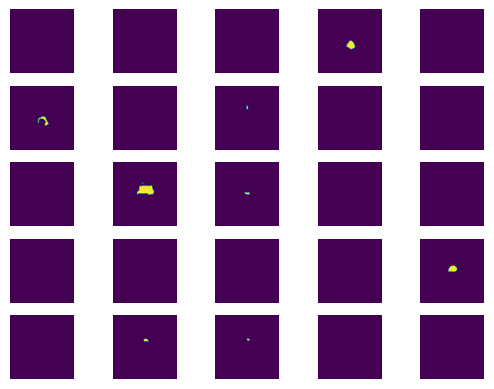

In [ ]:
# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(dataset_gt_array[i*3])
plt.show()

### ***Image Data generator***

In [ ]:
import os
#import numpy as np
import tensorflow
from tensorflow.keras.utils import to_categorical


def load_img(ct_scan_array, gt_array):

    images=[]
    ground_truth_list = []

    for i in range(ct_scan_array.shape[0]):


      ct_scan_slice = ct_scan_array[i]
      gt = gt_array[i]

      #n_classes = len(np.unique(gt))

      #Applying one hot encoding

      n_classes = 2

      image_ground_truth = to_categorical(gt, num_classes=n_classes)

      ground_truth_list.append(image_ground_truth)


      # Appying MinMax Scaler to normalize the images values from 0-255 to 0-1 range
      try:

        ct_scan_slice = scaler.fit_transform(ct_scan_slice.reshape(-1, ct_scan_slice.shape[-1])).reshape(ct_scan_slice.shape)

        pass

      except Exception as e:

        ct_scan_slice = scaler.fit_transform(ct_scan_slice.reshape(-1, ct_scan_slice.shape[-1])).reshape(ct_scan_slice.shape)

        pass

      images.append(ct_scan_slice)

      pass

    images = np.array(images)
    ground_truth_list = np.array(ground_truth_list)

    return(images,ground_truth_list)


In [ ]:
def imageLoader(ct_scan_array, gt_array, batch_size):

    L = ct_scan_array.shape[0]

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X , Y = load_img(ct_scan_array[batch_start:limit], gt_array[batch_start:limit])


            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
image_datagenerator = imageLoader(dataset_array,dataset_gt_array,batch_size=20)

X,Y = image_datagenerator.__next__()

In [ ]:
print(X.shape,Y.shape)

(20, 256, 256, 1) (20, 256, 256, 2)


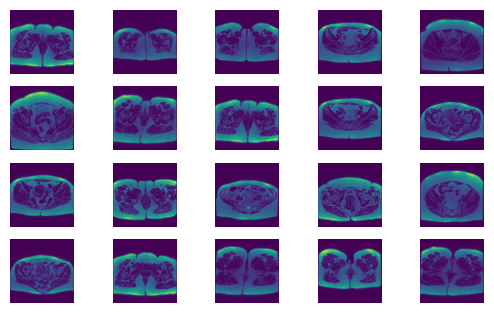

In [ ]:
# plot 25 images
for i in range(20):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i*1])
plt.show()

In [ ]:
################################################################
def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [ ]:
model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
from keras import backend as K

In [ ]:
smooth = 1.

def dice_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_similarity_coefficient(y_true, y_pred)

In [ ]:
def jaccard_similarity_coefficient(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    return (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)

In [ ]:
!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

IOU_score = sm.metrics.IOUScore(threshold=0.5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
import keras
from keras import backend as K

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



Specificity = keras.metrics.SpecificityAtSensitivity(0.5)

Sensitivity = keras.metrics.SensitivityAtSpecificity(0.5)

precision_metric = keras.metrics.Precision(thresholds=0)

In [ ]:
import keras
import tensorflow as tf
import segmentation_models as sm

###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1 = 0.50, 0.50

from tensorflow.keras.metrics import MeanIoU

############################################# LOSS Functions

dice_loss = sm.losses.DiceLoss(class_weights=[wt0, wt1])
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

crossentropy_loss = 'categorical_crossentropy'

selected_loss_function = total_loss
############################################## Model performance evaluation metrices

metrics = ['accuracy',IOU_score,jaccard_similarity_coefficient,dice_similarity_coefficient,recall_score,precision_score,f1_score,Specificity,Sensitivity]


############################################## Optimizer (Learning Algorithm)

#Learning_Rate = 0.0001
Learning_Rate = 0.001 # 4 5  bigger smaller its global adaptive
optimizer = tf.keras.optimizers.Adam(Learning_Rate)
#######################################################################


############################################## defining batch size

batch_size = 10

############################################## defining training steps on each epoch


steps_per_epoch = ct_scan_array[:,:,0:390].shape[2]//batch_size                 # 80 %
validation_steps_per_epoch = ct_scan_array[:,:,389:].shape[2]//batch_size                # 20 %


############################################## Number of epochs

number_of_epochs = 100



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Model Callbacks functions

##########################################################################################


model_file_path = '/content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5'

csv_file_path = '/content/drive/MyDrive/ct scans/bladder_segmentation_unet_history.csv'


history_logger = tf.keras.callbacks.CSVLogger(filename=csv_file_path,separator=",",append=True)

checkpoint = ModelCheckpoint(model_file_path, monitor="val_loss", save_best_only=False, verbose=2)

##########################################################################################

In [ ]:

############################################## Calling Image data generators

train_image_data_generator = imageLoader(dataset_array[0:390],dataset_gt_array[0:390],batch_size=10)


validation_image_data_generator = imageLoader(dataset_array[389:],dataset_gt_array[389:],batch_size=20)


In [ ]:
model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)



In [ ]:
############################################# Compiling Model

model.compile(optimizer = optimizer, loss=total_loss, metrics=metrics)

In [ ]:
from keras.models import load_model
############################################## Loading previously trained UNET MODEL
#path = '/content/drive/MyDrive/dataset/training history/unet_model.hdf5'

path = '/content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5'

model = load_model(path,custom_objects={'iou_score':IOU_score,
                                        'jaccard_similarity_coefficient':jaccard_similarity_coefficient,
                                        'dice_similarity_coefficient':dice_similarity_coefficient,
                                        'recall_score':recall_score,'precision_score':precision_score,
                                         'f1_score':f1_score,'Specificity':Specificity,
                                          'Sensitivity':Sensitivity,'focal_loss':focal_loss})

In [ ]:
history=model.fit(train_image_data_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=number_of_epochs,
          callbacks=[[history_logger],[checkpoint]],
          verbose=1,
          validation_data=validation_image_data_generator,
          validation_steps=validation_steps_per_epoch,
          )


model.save('/content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5')

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7779 - accuracy: 0.9647 - iou_score: 0.4834 - jaccard_similarity_coefficient: 0.8023 - dice_similarity_coefficient: 0.8673 - recall_score: 0.9647 - precision_score: 0.9647 - f1_score: 0.9647 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9977
Epoch 1: saving model to /content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 47s 7s/step - loss: 0.7779 - accuracy: 0.9647 - iou_score: 0.4834 - jaccard_similarity_coefficient: 0.8023 - dice_similarity_coefficient: 0.8673 - recall_score: 0.9647 - precision_score: 0.9647 - f1_score: 0.9647 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9977
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.9976 - iou_score: 0.4988 - jaccard_similarity_coefficient: 0.9953 - dice_similarity_coefficient: 0.9976 - recall_score: 0.9976 - precision_score: 0.9976 - f1_score: 0.9976 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9977
Epoch 2: saving model to /content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 44s 7s/step - loss: 0.7550 - accuracy: 0.9976 - iou_score: 0.4988 - jaccard_similarity_coefficient: 0.9953 - dice_similarity_coefficient: 0.9976 - recall_score: 0.9976 - precision_score: 0.9976 - f1_score: 0.9976 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9977
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.9985 - iou_score: 0.4992 - jaccard_similarity_coefficient: 0.9970 - dice_similarity_coefficient: 0.9985 - recall_score: 0.9985 - precision_score: 0.9985 - f1_score: 0.9985 - specificity_at_sensitivity: 0.9985 - sensitivity_at_specificity: 0.9985
Epoch 3: saving model to /content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 44s 7s/step - loss: 0.7532 - accuracy: 0.9985 - iou_score: 0.4992 - jaccard_similarity_coefficient: 0.9970 - dice_similarity_coefficient: 0.9985 - recall_score: 0.9985 - precision_score: 0.9985 - f1_score: 0.9985 - specificity_at_sensitivity: 0.9985 - sensitivity_at_specificity: 0.9985
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.9977 - iou_score: 0.4988 - jaccard_similarity_coefficient: 0.9954 - dice_similarity_coefficient: 0.9977 - recall_score: 0.9977 - precision_score: 0.9977 - f1_score: 0.9977 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9977
Epoch 4: saving model to /content/drive/MyDrive/ct scans/bladder_segmentation_unet.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 43s 7s/step - loss: 0.7550 - accuracy: 0.9977 - iou_score: 0.4988 - jaccard_similarity_coefficient: 0.9954 - dice_similarity_coefficient: 0.9977 - recall_score: 0.9977 - precision_score: 0.9977 - f1_score: 0.9977 - specificity_at_sensitivity: 0.9977 - sensitivity_at_specificity: 0.9977
Epoch 5/100
3/6 [==============>...............] - ETA: 21s - loss: 0.6685 - accuracy: 0.9992 - iou_score: 0.6662 - jaccard_similarity_coefficient: 0.9983 - dice_similarity_coefficient: 0.9992 - recall_score: 0.9992 - precision_score: 0.9992 - f1_score: 0.9992 - specificity_at_sensitivity: 0.9992 - sensitivity_at_specificity: 0.9992

KeyboardInterrupt: ignored